In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Perfiles de densidad superficial Gadget

Galaxy  001
Rd =  3.36128 r50 =  2.40028
Md =  7.242e+09 Mgal =  1.377e+10


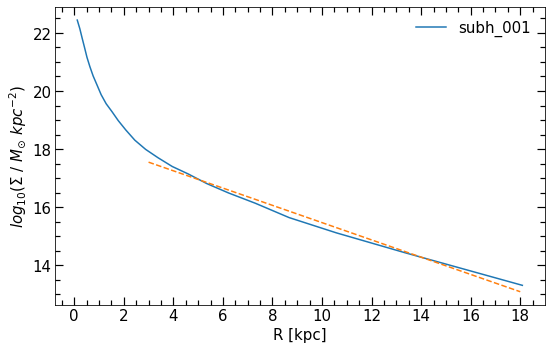

In [19]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
aa = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = aa[:,2]

# snapshot=range(496,300,-1) #SNAPSHOTS

path = '/mnt/is2/alejandro/ornella/'

colores = ('tab:blue','tab:orange','r','tab:green')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
fig.subplots_adjust(bottom=0.1, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)


# for isnap in snapshot:

isnap=496

halos = (0,1,3)

# for i in halos:
i=1
snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]

pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

z     = a0/aexp[isnap] - 1.
Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
r    = np.sqrt(xstr**2+ystr**2+zstr**2)

#paso las velocidades a unidades físicas
v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

mstr = mstr/h     #masa a unidades físicas

r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

rgal = 0.15*r200          #defino el radio de la galaxia

limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
razon = Mc_str/Mgal 
noventa, = np.where(razon < 0.9)
cincuenta, = np.where(razon < 0.5)

r90 = r_sort[noventa][-1]   #radio a 90% la masa
r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#componentes de la velocidad del centro de masa
veloc, = np.where(r < r50)

vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

#-------------------------------------------------------------------------------------
#hago la rotación de las coordenadas respecto del momento angular    
e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr*1e10,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

rn = np.sqrt(xn**2 + yn**2 + zn**2 )

limit, = np.where(rn < rgal )

R = np.sqrt(xn[limit]**2+yn[limit]**2)

nbin = 25
den, Rbin = density.surf_density(R,mstr[limit]*1e10,nbin)

cut, = np.where(Rbin > 3)
pol  = np.polyfit(Rbin[cut],np.log(den[cut]),1)

x1 = np.linspace(3,18)
y1 = pol[0]*x1 + pol[1]

Rd = -1./pol[0]

Md = 2*np.pi*np.exp(pol[1])*Rd**2

print 'Galaxy ', str('%03d'%i)
print 'Rd = ', '%1.5f'%Rd, 'r50 = ', '%1.5f'%r50
print 'Md = ', '%1.3e'%Md, 'Mgal = ', '%1.3e'%(Mgal*1e10)


ax.plot(Rbin, np.log(den), ls='-', label='subh_'+str('%03d'%i))
ax.plot(x1,y1,'--',color=colores[i])

ax.set_xticks([0,2,4,6,8,10,12,14,16,18])
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
# ax.set_xlim(0,14)
ax.set_ylabel('$log_{10}$($\Sigma$ / $M_{\odot}$ $kpc^{-2}$)',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.legend(fontsize=15,frameon=False)

# fig.savefig('../_imagenes/surf_density.png',dpi=100, xxbox_inches='tight')

## Perfiles de densidad superficial Gasoline

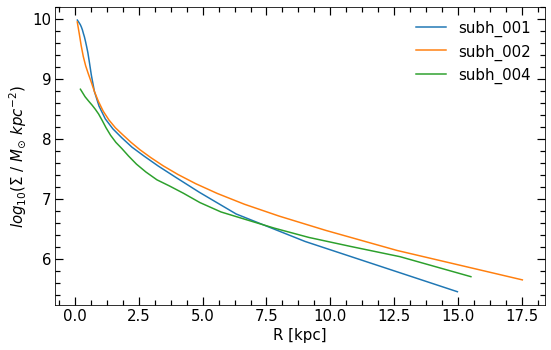

In [5]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

# path = '/home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
snapshot = snapshot[::-1]

colores = ('r','tab:blue','tab:orange','r','tab:green')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
fig.subplots_adjust(bottom=0.1, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)

# for j in range(len(snapshot)-1,32,-1):
j=0

halos = (1,2,4)

for i in halos:
# i=1
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
    time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
    h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
    aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    #paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    #----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #-----------------------------------------------------------------------

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

        #-----------------------------------------------------------------------------------

        #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rn = np.sqrt(xn**2 + yn**2 + zn**2 )
    
    limit, = np.where(rn < rgal )
    
    R = np.sqrt(xn[limit]**2+yn[limit]**2)
    
    nbin = 25
    den = density.surf_density(R,mstr[limit],nbin)
    
    ax.plot(den[1],np.log10(den[0]), ls='-', label='subh_'+str('%03d'%i))

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
# ax.set_xlim(0,14)
ax.set_ylabel('$log_{10}$($\Sigma$ / $M_{\odot}$ $kpc^{-2}$)',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.legend(fontsize=15,frameon=False)
